PotatoCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=65536, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
  (relu): ReLU()
)
Epoch 1, Loss: 0.4990
Epoch 2, Loss: 0.2446
Epoch 3, Loss: 0.1784
Epoch 4, Loss: 0.1354
Epoch 5, Loss: 0.0849
Epoch 6, Loss: 0.0693
Epoch 7, Loss: 0.0453
Epoch 8, Loss: 0.0404
Epoch 9, Loss: 0.0308
Epoch 10, Loss: 0.0251
Accuracy: 0.9629, F1 Score: 0.9628, Recall: 0.9629


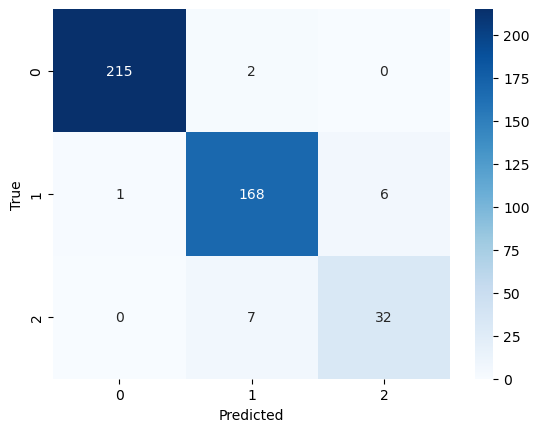

(0.962877030162413, 0.9627785957257674, 0.962877030162413)

In [8]:

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize all images
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize([0.5], [0.5])  # Normalize
])

# Load dataset from a single directory
dataset = datasets.ImageFolder(root="dataset-potato", transform=transform)

# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define PyTorch Model (Equivalent to TensorFlow Model)
class PotatoCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(PotatoCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)  # Adjust the size based on image dimensions
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PotatoCNN().to(device)
print(model)

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training Loop
def train_model(model, train_loader, num_epochs=60):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

# Function for Evaluation
def evaluate_model(model, dataloader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)
    
    print(f'Accuracy: {acc:.4f}, F1 Score: {f1:.4f}, Recall: {recall:.4f}')
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    return acc, f1, recall

# Train and Evaluate Model
train_model(model, train_loader, num_epochs=10)
evaluate_model(model, val_loader)


In [9]:
# Save the model
torch.save(model.state_dict(), "potato-detection-model.pth")
print("Model saved successfully!")


Model saved successfully!
